# Посмотрим на поведение разных loss функций на примере линейной регрессии

Возьмем очень простые данные о поситителях торгового центра и будем предсказывать некий score-балл, отвечающий количеству и частоте их покупок.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('Mall_Customers.csv')
data = data.sample(frac = 1)
data.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
178         179    Male   59                  93                      14
83           84  Female   46                  54                      44
131         132    Male   39                  71                      75
147         148  Female   32                  77                      74
170         171    Male   40                  87                      13

Проведем предобработку данных данных

In [3]:
data.loc[data['Gender'] == 'Male', 'Gender'] = 0
data.loc[data['Gender'] == 'Female', 'Gender'] = 1

In [4]:
data["Age"]=((data["Age"]-data["Age"].min())/(data["Age"].max()-data["Age"].min()))
data["Annual Income (k$)"]=((data["Annual Income (k$)"]-data["Annual Income (k$)"].min())/(data["Annual Income (k$)"].max()-data["Annual Income (k$)"].min()))

In [5]:
y_test = data['Spending Score (1-100)'][int(data.shape[0] * 0.7):].values
X_test = data.drop(columns = ['CustomerID', 'Spending Score (1-100)'])[int(data.shape[0] * 0.7):].values

In [6]:
y = data['Spending Score (1-100)'][:int(data.shape[0] * 0.7)].values
X = data.drop(columns = ['CustomerID', 'Spending Score (1-100)'])[:int(data.shape[0] * 0.7)].values

Сравнивать все модели будем по метрике похожей на на accuracy. Если y_pred $\in$ [y\*0.9, y\*1.1], то считаем, что мы угадали.

In [7]:
def accur(y, y_pred):
    ac = 0
    for i in range(len(y)):
        if (abs(y[i] - y_pred[i]) / y[i] < 0.1):
            ac = ac + 1
    return ac*1.0 / len(y)

## Первый лосс - квадратичный

In [8]:
W = None
b = None

def mse(preds, y):
    return ((preds - y)**2).mean()
    
def grad_descent(X, y, lr, num_iter=100):
    global W, b
    np.random.seed(42)
    W = np.random.rand(X.shape[1])
    b = np.array(np.random.rand(1))
    #print W, b
    
    losses = []
    
    N = X.shape[0]
    for iter_num in range(num_iter):
        preds = predict(X)
        losses.append(mse(preds, y))
        
        w_grad = np.zeros_like(W)
        b_grad = 0
        for sample, prediction, label in zip(X, preds, y):
            w_grad += 2 * (prediction - label) * sample
            b_grad += 2 * (prediction - label)
            
            W -= lr * w_grad
            b -= lr * b_grad
        if iter_num % 100 ==0:
            lr = lr * 0.5
    return losses

def predict(X):
    global W, b
    return np.squeeze(np.dot(X, W) + b.reshape(-1, 1))

In [9]:
losses = grad_descent(X, y, 1e-5, 1000)

In [10]:
W, b

(array([  7.1411515, -21.134347 ,   5.5755219]), array([50.62851877]))

619.2508854371024


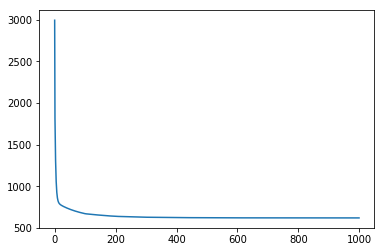

In [11]:
plt.plot(losses)
print losses[-1];

In [12]:
y_pred = predict(X)
for i in range(10):
    print y[i], y_pred[i]

14 37.52957695846236
44 48.171976243138865
75 44.652749975136736
74 54.91311572435866
13 44.9775362124869
88 55.94960097741494
55 39.45902674002318
97 49.590245702584454
43 32.50067923260069
66 50.0898652640545


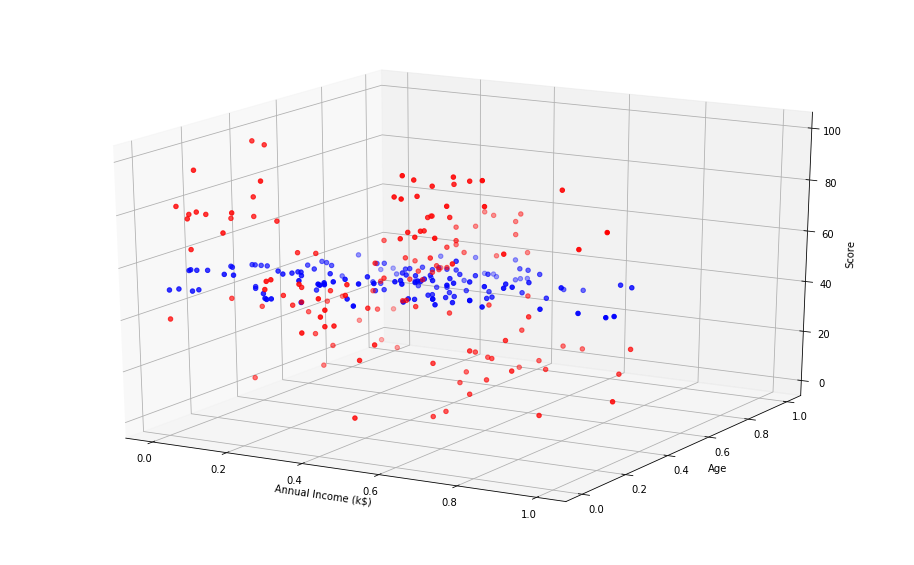

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
#X, Y = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 150, 100))
#ax.scatter(xs=X_norm[:, 2], ys=X_norm[:,1], zs=y_norm, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y_pred, c='b')
#ax.plot_surface(X,Y, W[2]*X + W[1]*Y + b, color='green', alpha=0.3)
#ax.plot_surface(X,Y, W[0]*X + W[1]*Y + b, color='blue', alpha=0.3)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Age')
ax.set_zlabel('Score')
ax.view_init(elev=20)

In [16]:
print accur(y, y_pred)
print accur(y_test, predict(X_test))

0.0857142857143
0.183333333333


Мини-вывод: Видим, что данные не линейные, но получилось, в целом, неплохо. 

## Линейная лосс-функция

In [17]:
W_l = None
b_l = None

def loss_l(preds, y):
    return (abs(preds - y)).mean()
    
def grad_descent_l(X, y, lr, num_iter=100):
    global W_l, b_l
    np.random.seed(42)
    W_l = np.random.rand(X.shape[1])
    b_l = np.array(np.random.rand(1))
    
    losses = []
    
    N = X.shape[0]
    for iter_num in range(num_iter):
        preds = predict_l(X)
        losses.append(loss_l(preds, y))
        
        w_grad = np.zeros_like(W_l)
        b_grad = 0
        for sample, prediction, label in zip(X, preds, y):
            if (prediction - label)> 0:
                w_grad += sample
                b_grad += 1
            else:
                w_grad -= sample
                b_grad -= 1
            
            W_l-= lr * w_grad
            b_l-= lr * b_grad
        if iter_num % 100 ==0:
            lr = lr * 0.5
    return losses

def predict_l(X):
    global W_l, b_l
    return np.squeeze(np.dot(X, W_l) + b_l.reshape(-1, 1))

In [18]:
losses = grad_descent_l(X, y, 1e-5, 1000)

In [19]:
W_l, b_l

(array([5.03437356, 4.24451379, 4.05821051]), array([9.17961927]))

36.07170174732589


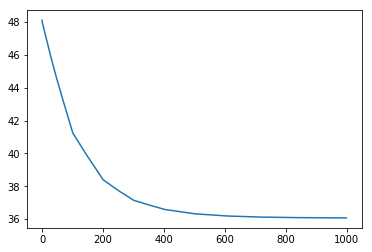

In [20]:
plt.plot(losses)
print losses[-1];

In [21]:
y_pred = predict_l(X)
for i in range(10):
    print y[i], y_pred[i]

14 15.1208487363288
44 17.79679704549529
75 12.756534982533953
74 17.419115806383395
13 13.37038457619539
88 17.04118392893966
55 19.75887298039737
97 12.953300171603267
43 14.85755550618946
66 9.542453918859966


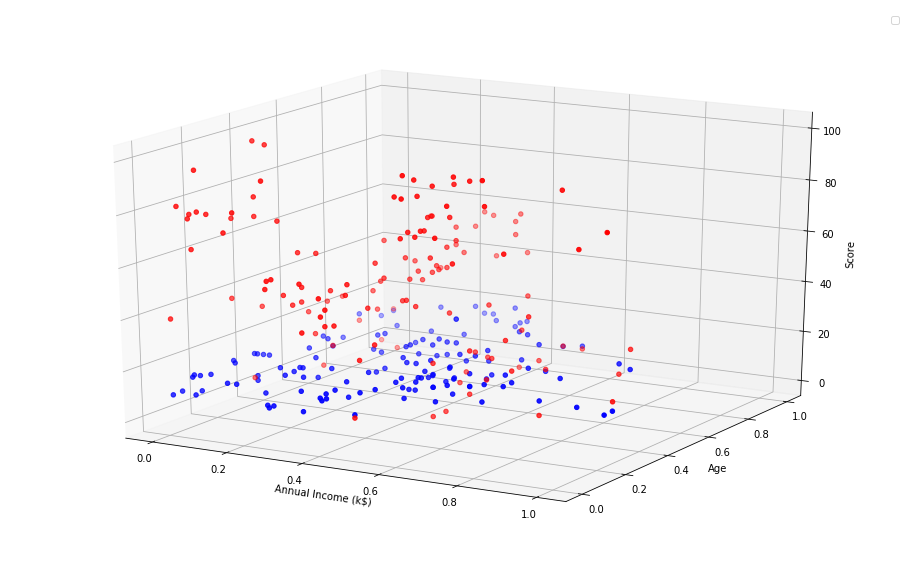

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
#X, Y = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 150, 100))
#ax.scatter(xs=X_norm[:, 2], ys=X_norm[:,1], zs=y_norm, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y_pred, c='b')
#ax.plot_surface(X,Y, W[2]*X + W[1]*Y + b, color='green', alpha=0.3)
#ax.plot_surface(X,Y, W[0]*X + W[1]*Y + b, color='blue', alpha=0.3)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Age')
ax.set_zlabel('Score')
ax.view_init(elev=20)


In [23]:
print accur(y, y_pred)
print accur(y_test, predict_l(X_test))

0.05
0.0166666666667


Мини-вывод: Работает значительно медленнее, что видно про графику лосса и визуализации данных. Изменим learning_rate, чтобы обучалось быстрее.

In [26]:
losses = grad_descent_l(X, y, 1e-3, 1000)

20.40622319467327


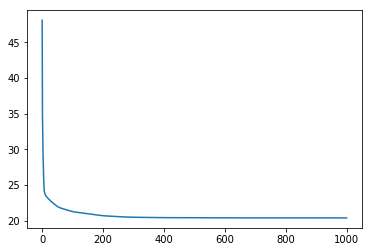

In [27]:
plt.plot(losses)
print losses[-1];

In [28]:
y_pred = predict_l(X)
for i in range(10):
    print y[i], y_pred[i]

14 40.76575816066298
44 43.999828948781214
75 48.729443292459415
74 49.4986515851531
13 48.30186375871606
88 50.694585341097564
55 35.277653781747944
97 52.23833106457862
43 37.260816063329486
66 56.352353735798104


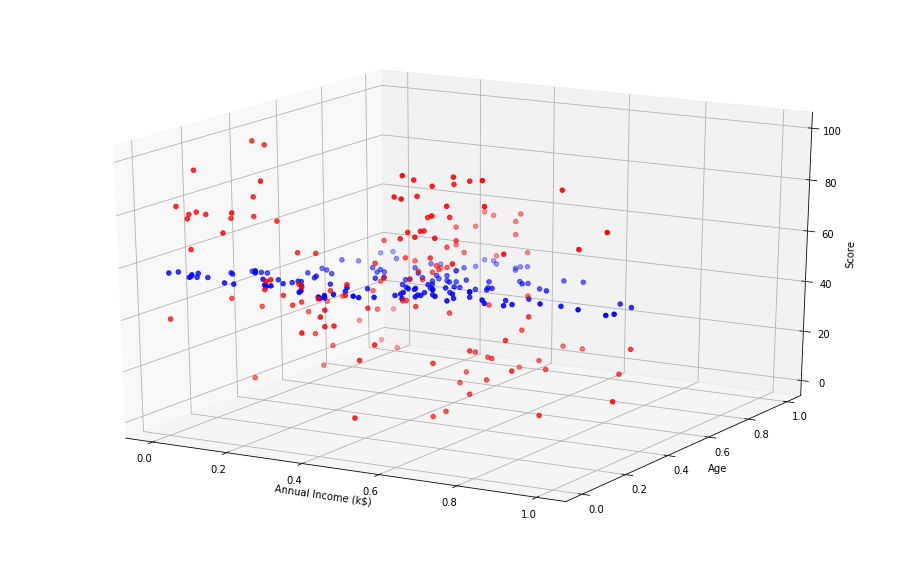

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
#X, Y = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 150, 100))
#ax.scatter(xs=X_norm[:, 2], ys=X_norm[:,1], zs=y_norm, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y_pred, c='b')
#ax.plot_surface(X,Y, W[2]*X + W[1]*Y + b, color='green', alpha=0.3)
#ax.plot_surface(X,Y, W[0]*X + W[1]*Y + b, color='blue', alpha=0.3)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Age')
ax.set_zlabel('Score')

ax.view_init(elev=20)

In [30]:
print accur(y, y_pred)
print accur(y_test, predict_l(X_test))

0.15
0.2


Мини-вывод: Действительно, работает не хуже квадратичной функции.

## Попробуем сделать несимметричную функцию потерь 

Будем штрафовать за преувеличение больше. Чтобы оценить работу, будем обучать на данных как в первом линейном случае(когда мы плохо оценивали большие значения

In [31]:
W_as = None
b_as = None


def loss_as(preds, y, a, c):
    s = 0
    for i in range(len(y)):
        if preds[i] > y[i]:
            s = s + a*abs(preds[i] - y[i])
        else:
            s = s + c*abs(preds[i] - y[i])
    return s

def grad_descent_as(X, y, lr, num_iter=100, a=1, c=1):
    global W_as, b_as
    np.random.seed(42)
    W_as = np.random.rand(X.shape[1])
    b_as = np.array(np.random.rand(1))

    
    losses = []
    
    N = X.shape[0]
    for iter_num in range(num_iter):
        preds = predict_as(X)
        losses.append(loss_as(preds, y, a, c))
        
        w_grad = np.zeros_like(W_as)
        b_grad = 0
        for sample, prediction, label in zip(X, preds, y):
            if (prediction - label)> 0:
                w_grad += a*sample
                b_grad += 1
            else:
                w_grad -= c*sample
                b_grad -= 1
            
            W_as -= lr * w_grad
            b_as -= lr * b_grad
        if iter_num % 100 ==0:
            lr = lr * 0.5
    return losses

def predict_as(X):
    global W_as, b_as
    return np.squeeze(np.dot(X, W_as) + b_as.reshape(-1, 1))

In [32]:
losses = grad_descent_as(X, y, 1e-5, 1000, 1, 5)

16845.945435026646


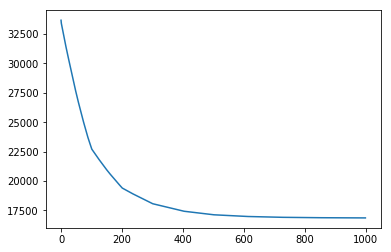

In [33]:
plt.plot(losses)
print losses[-1];

In [34]:
y_pred = predict_as(X)
for i in range(10):
    print y[i], y_pred[i]

14 29.452191923572535
44 42.06965915865356
75 20.60206263356475
74 40.70814660739784
13 22.920098042884696
88 39.292515115817906
55 49.38801240178725
97 21.390145191897574
43 28.41236051358608
66 8.531494016497007


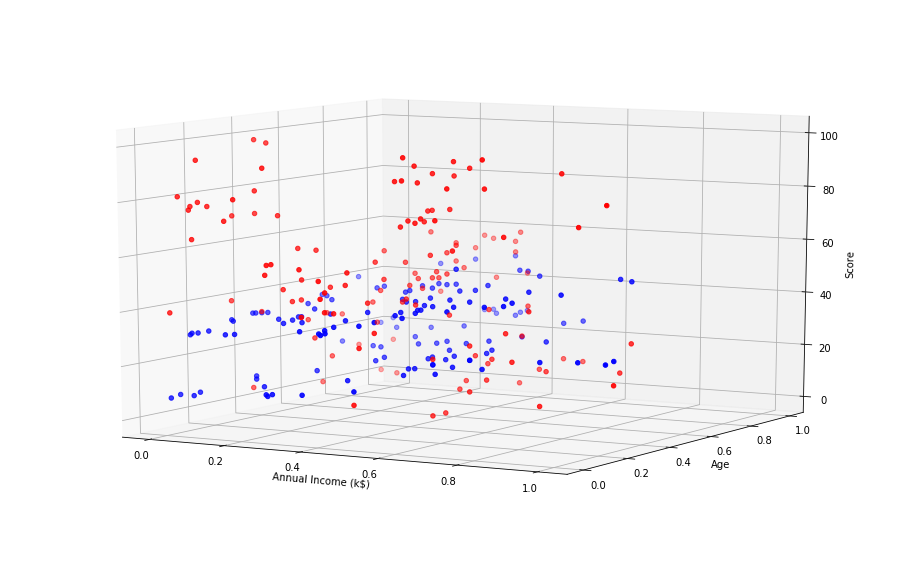

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
#X, Y = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 150, 100))
#ax.scatter(xs=X_norm[:, 2], ys=X_norm[:,1], zs=y_norm, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y, c='r')
ax.scatter(xs=X[:, 2], ys=X[:, 1], zs=y_pred, c='b')
#ax.plot_surface(X,Y, W[2]*X + W[1]*Y + b, color='green', alpha=0.3)
#ax.plot_surface(X,Y, W[0]*X + W[1]*Y + b, color='blue', alpha=0.3)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Age')
ax.set_zlabel('Score')
ax.view_init(elev=10)

Мини-вывод: Видим, что уровень поднялся. Таким образом, делая взвешенный лосс можно расставить наши приоритеты.

Лучше всего квадратичный! На нем и будем смотреть регуляризацию.
Но это уже в следующем ноутбуке
